# Collaborative Filtering: Cosine Similarity

## Alex Riley, Apr 23 2018

In another Jupyter Notebook, we applied Collaborative Filtering to a subset of the MovieLens dataset utilizing the Pearson correlation coefficient as the weights for how similar two users were.  Here we will use another metric: the cosine similarity

$$ sim(u,u') = cos(\theta{}) = \frac{\textbf{r}_{u} \dot{} \textbf{r}_{u'}}{\| \textbf{r}_{u} \| \| \textbf{r}_{u'} \|} = \sum_{i} \frac{r_{ui}r_{u'i}}{\sqrt{\sum\limits_{i} r_{ui}^2} \sqrt{\sum\limits_{i} r_{u'i}^2} } $$

We'll take a similar approach as the other notebook

## Load data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from utils import predict_full, train_test_split, mse

For this notebook we downloaded the subset of the MovieLens dataset that only contains 100,000 ratings

In [2]:
ratings = pd.read_csv('data/ratings.csv',header=0)
ratings = ratings.pivot_table(index='userId',columns='movieId',values='rating')
ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will find it useful when we are calculating similarities later to replace NaNs with 0.0.  It's important to keep in the back of our minds that this is the case, and that 0.0 does not mean a rating of zero stars.

In [3]:
ratings.fillna(value=0.0, inplace=True)

## Split into train/test

We can turn the data into training and test sets by 
* making two copies of the ratings dataframe
* for each user, select a percentage of ratings (removing 0s)
    * in the training data, set these values to 0.0
    * in the test data, set everything else to 0.0

In [4]:
train, test = train_test_split(ratings, empty=0.0, testfrac=0.2)

We can check our work by verifying that ~80% of the entries in each row are in the training set

In [5]:
(train.astype(bool).sum(axis=1)/ratings.astype(bool).sum(axis=1)).head(n=7)

userId
1    0.800000
2    0.802632
3    0.803922
4    0.803922
5    0.800000
6    0.818182
7    0.806818
dtype: float64

## Applying cosine similarity

The cosine similarity is a common metric used in collaborative filtering algorithms.  It can be helpful to visualize each user's ratings as a vector &mdash; the cosine of the angle between vectors gives some measure of similarity between the two.

$$ sim(u,u') = cos(\theta{}) = \frac{\textbf{r}_{u} \dot{} \textbf{r}_{u'}}{\| \textbf{r}_{u} \| \| \textbf{r}_{u'} \|} = \sum_{i} \frac{r_{ui}r_{u'i}}{\sqrt{\sum\limits_{i} r_{ui}^2} \sqrt{\sum\limits_{i} r_{u'i}^2} } $$

Given the middle formula, with a matrix composed of vectors it's easy to see as the dot product between the matrix and its transpose, divided by the product of norms and norms transposed (see code)

In [6]:
def cosine_sim(df):
    vals = df.values
    sim = vals @ vals.T
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

In [7]:
similarity = cosine_sim(train)
similarity[:5, :5]

array([[1.        , 0.        , 0.        , 0.04853111, 0.02087526],
       [0.        , 1.        , 0.06751264, 0.09836583, 0.08691326],
       [0.        , 0.06751264, 1.        , 0.05375295, 0.13514057],
       [0.04853111, 0.09836583, 0.05375295, 1.        , 0.10322219],
       [0.02087526, 0.08691326, 0.13514057, 0.10322219, 1.        ]])

As we can see, we get a weighting factor that is symmetric with the diagonal equal to 1 (corresponding to the $\cos(\theta)$ of a vector with itself).  Higher values of $\cos(\theta)$ indicate a stronger impact.  We can plot the distribution of weights in both linear and log-space bins (note this is very rough, since non-diagonal values are counted twice)

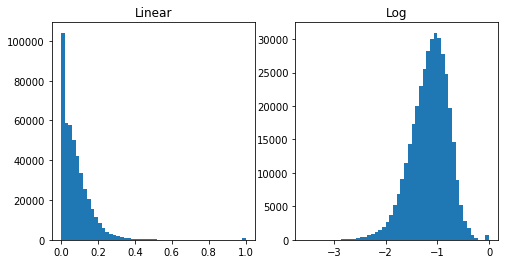

In [8]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(similarity.flatten(), bins=50)
plt.title('Linear')

plt.subplot(1,2,2)
plt.hist(np.log10(similarity[similarity != 0].flatten()), bins=50)
plt.title('Log');

## Predicting ratings

Now that our weights are computed, we can assign a predicted rating to the test set and see how well we did

In [9]:
prediction = predict_full(train, similarity)

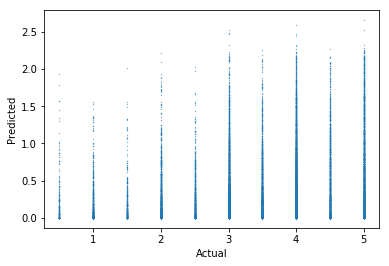

In [10]:
plt.plot(test.values[test.values > 0], prediction.values[test.values > 0], '.', ms=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted');

That doesn't look very good at all. For the sake of comparison to the Pearson correlation scheme, let's compute the MSE

In [11]:
mse(pred=prediction, actual=test)

10.814740332147446